# Рекомендательная системма релевантных треков для пользователей

**Выполнила:** Антропова Ольга

**Что будет оцениваться**
- наличие и содержательность разведочного анализа данных;
- пайплайн обучения: подготовка данных, feature engineering, выбор модели, выбор loss-функции, корректная оценка метрик качества.
- финальный скор.

### **Содержание**

- <a href='#section1'>Описание данных</a>
- <a href='#section2'>Установка используемых библиотек</a>
- <a href='#section3'>Импортирование необходимых библиотек</a>
- <a href='#section4'>Загрузка тренировочного датасета</a>
- <a href='#section5'>Разделение датасета на train и val</a>
- <a href='#section6'>Аугментация и подготовка изображений</a>
- <a href='#section7'>Подготовка тестовых данных</a>
- <a href='#section8'>Обучение модели</a>
- <a href='#section9'>Предсказание и выгрузка результатов</a>
- <a href='#section10'>Результаты</a>
- <a href='#section11'>Дополнительные эксперименты</a>


<b><h3 id="section1">Описание данных</h3></b>

- **train.csv**
    - msno - идентификатор пользователя
    - song_id - идентификатор песни
    - source_system_tab - название вкладки, на которой запущено событие
    - source_screen_name - название макета, который видит пользователь
    - source_type - точка входа, с которой пользователей впервые воспроизводит музыку в мобильном приложении
    - target - целевая переманная (1 - в течение месяца после самого первого наблюдаемого пользователем события прослушивания запускаются повторяющиеся события прослушивания, в противном случае - 0)


- **test.csv**
    - id - идентификатор строки (используется для отправки)
    - msno - идентификатор пользователя
    - song_id - идентификатор песни
    - source_system_tab - название вкладки, на которой запущено событие
    - source_screen_name - название макета, который видит пользователь
    - source_type - точка входа, с которой пользователей впервые воспроизводит музыку в мобильном приложении

 
- **songs.csv**
    - song_id - идентификатор песни
    - song_lenght - продолжительности песни (измеряется в ms)
    - genre_ids - категория жанра, некоторые песни имеют несколько жанров и разделены |
    - artist_name - имя исполнителя
    - composer - композитор
    - lyricist - автор текста
    - language - язык песни


- **members.csv**
    - msno - идентификатор пользователя
    - city - город
    - bd - возраст (в этом столбце есть значения с отклонениями, выбирать на свой страх и риск)
    - gender - пол
    - registered_via - способ регистрации
    - registration_init_time - время регистрации (%Y%m%d)
    - expiration_date - дата истечения срока действия (%Y%m%d)


- **song_extra_info.csv**
    - song_id - идентификатор песни
    - song_name - название песни
    - isrc - международный стандартный код записи,  теоретически может использоваться в качестве идентификатора песни

<b><h3 id="section2">Импортирование необходимых библиотек</h3></b>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<b><h3 id="section2">Загрузка датасетов</h3></b>

Загружаем имеющиеся датасеты и объединяем их в один.

In [52]:
train = pd.read_csv('data/train.csv')
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [53]:
members = pd.read_csv('data/members.csv')
train = pd.merge(train, members, on='msno', how='left')

In [54]:
songs = pd.read_csv('data/songs.csv')
train = pd.merge(train, songs, on='song_id', how='left')

In [55]:
del members
del songs

<b><h3 id="section3">Разведочный анализ данных</h3></b>

In [6]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   city                    int64  
 7   bd                      int64  
 8   gender                  object 
 9   registered_via          int64  
 10  registration_init_time  int64  
 11  expiration_date         int64  
 12  song_length             float64
 13  genre_ids               object 
 14  artist_name             object 
 15  composer                object 
 16  lyricist                object 
 17  language                float64
dtypes: float64(2), int64(6), object(10)
memory usage: 1013.1+ MB


Как числовые, так и категориальные признаки.

In [8]:
dtypes = pd.DataFrame(train.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=train.nunique().sort_values(ascending=True)

dtypes["Null Values"]=train.isnull().sum()

dtypes["% null Values"]=train.isnull().sum()/len(train)

dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% null Values
lyricist,object,33887,3178812,0.430884
gender,object,2,2961479,0.401425
composer,object,76064,1675706,0.227140
source_screen_name,object,20,414804,0.056226
genre_ids,object,572,118455,0.016056
source_system_tab,object,8,24849,0.003368
source_type,object,12,21539,0.002920
language,float64,10,150,0.000020
artist_name,object,40582,114,0.000015
song_length,float64,60266,114,0.000015


Как видим, много пропусков в колонках с авторами текстов, композиторами и полом. Можно попробовать заменить эти значения на что-то вроде "unknown", но есть шанс, что это повлияет на обучение.

Рассмотрим подробнее колонки с числовыми данными, в которых есть пропуски: song_lenght, language.

In [11]:
train['language']

0          52.0
1          52.0
2          52.0
3          -1.0
4          52.0
           ... 
7377413    52.0
7377414    52.0
7377415     3.0
7377416    52.0
7377417    52.0
Name: language, Length: 7377418, dtype: float64

In [18]:
train['language'].value_counts()

language
 3.0     4044643
 52.0    1864789
 31.0     656623
-1.0      308752
 17.0     245136
 10.0     171904
 24.0      78621
 59.0       4193
 45.0       2397
 38.0        210
Name: count, dtype: int64

Каким-то образом закодирован язык песни в виде числа. Не имеет смысла выбирать среднее значение для заполнения пропусков, возьмем моду, то есть значение 3.0.

In [56]:
languages = train['language'].unique().tolist()
mode = train['language'].mode()[0]
train['language'] = train['language'].fillna(mode)

Теперь посмотрим на song_lenght:

In [57]:
train['song_length'].value_counts()

song_length
235415.0    18749
258298.0    18440
219324.0    17756
250357.0    17740
265508.0    16452
            ...  
68405.0         1
304911.0        1
181953.0        1
217323.0        1
485575.0        1
Name: count, Length: 60266, dtype: int64

Логично заменить пропуски на среднюю продолжительность песни.

In [58]:
mean_length = train['song_length'].mean()
train['song_length'].fillna(mean_length, inplace=True)

Проверим, что у нас заполнились пропуски в этих колонках

In [59]:
print(train['language'].isnull().sum())
print(train['song_length'].isnull().sum())

0
0


Категориальные данные пока не будем заменять, просто удалим 3 столбца с наибольшим количеством пропусков и те строчки, в которых есть пропуски.

In [60]:
train = train.drop(['lyricist', 'gender', 'composer'], axis=1)

In [61]:
train.dropna(subset=['source_system_tab', 
                     'source_screen_name', 
                     'source_type',
                     'artist_name',
                     'genre_ids'],
            inplace=True)

In [62]:
train.isnull().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
city                      0
bd                        0
registered_via            0
registration_init_time    0
expiration_date           0
song_length               0
genre_ids                 0
artist_name               0
language                  0
dtype: int64

Переведем даты в нужный формат:

In [63]:
train['registration_init_time'] = pd.to_datetime(train['registration_init_time'], format='%Y%m%d', errors='ignore')
train['expiration_date'] = pd.to_datetime(train['expiration_date'], format='%Y%m%d', errors='ignore')

Можно попробовать извлечь дополнительные фичи в виде отдельно года, месяца и дня регистрации пользователя. Но пока кажется, что это излишне.

In [64]:
train['registration_init_time'] = train['registration_init_time'].astype('category')
train['expiration_date'] = train['expiration_date'].astype('category') 

In [65]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,7,2012-01-02,2017-10-05,206471.0,359,Bastille,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,9,2011-05-25,2017-09-11,225396.0,1259,Nas,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,52.0


Построим матрицу корреляции:

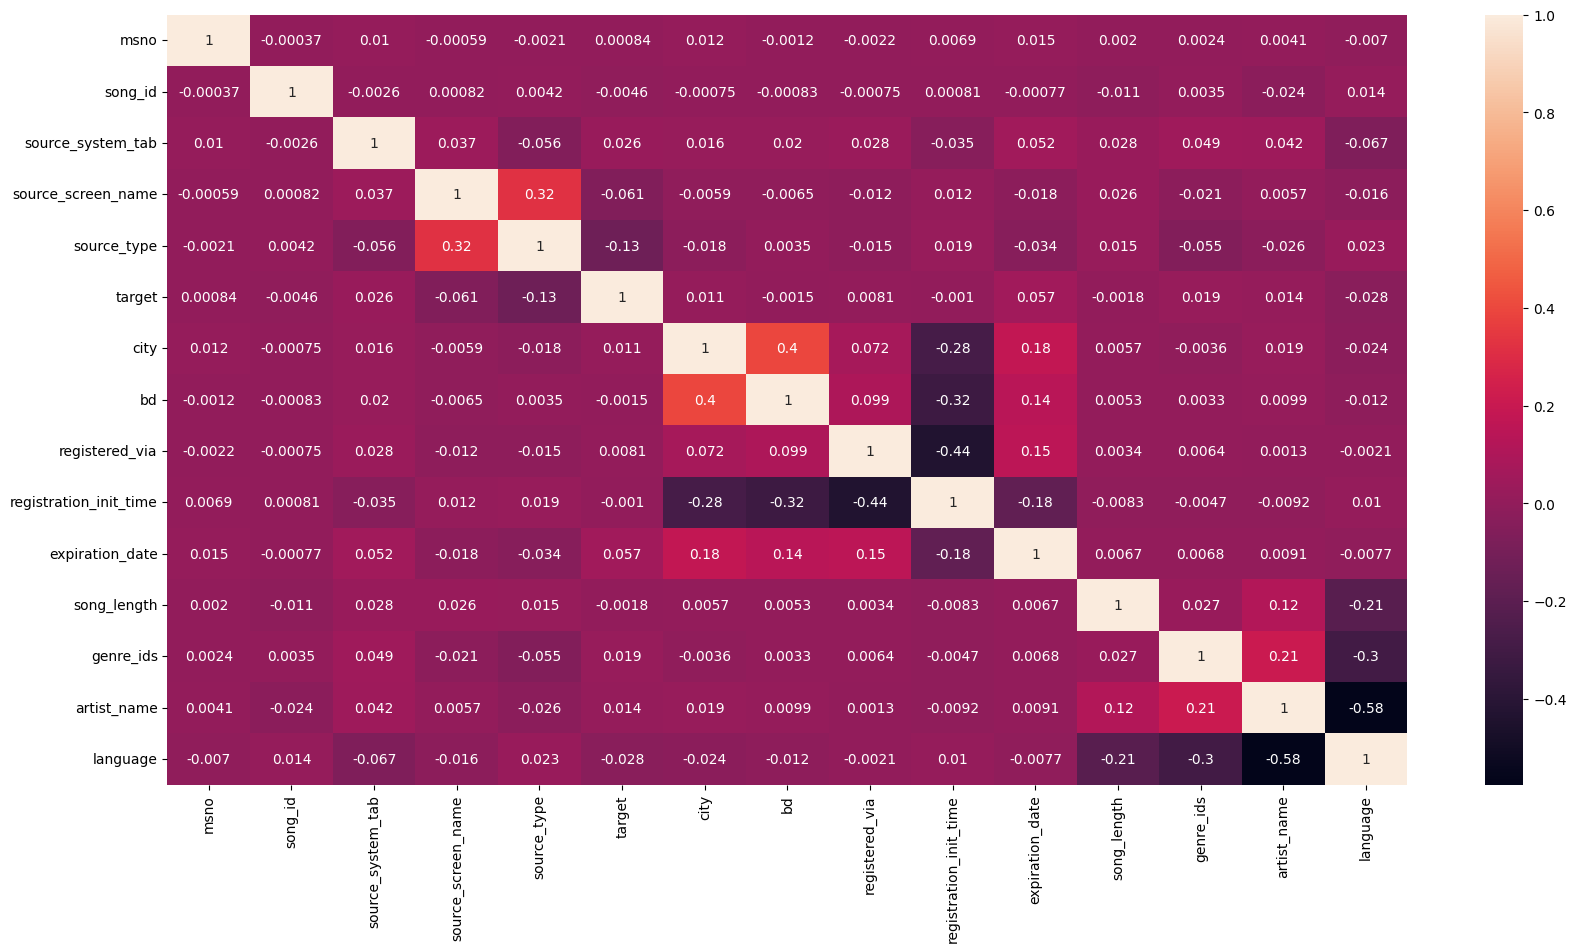

In [42]:
plt.figure(figsize=[20,10])
sns.heatmap(train.corr(), annot=True)
plt.show()

Поработаем с жанрами.

In [75]:
train['genre_ids'].value_counts()

genre_ids
465                   3483090
458                   1200533
921                    337623
1609                   300131
444                    228131
                       ...   
1969|275|2100|1572          1
921|1633                    1
1096|958                    1
338                         1
1609|947                    1
Name: count, Length: 567, dtype: int64

In [76]:
genres = set()
for row in train['genre_ids']:
    if pd.isnull(row):
        continue
    genres.update(row.split('|'))

In [77]:
for genre in genres:
    train[genre] = train['genre_ids'].apply(lambda x: 1 if genre in str(x) else 0)

C:\Users\Оля\AppData\Local\Temp\ipykernel_12492\2462623376.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[genre] = train['genre_ids'].apply(lambda x: 1 if genre in str(x) else 0)
C:\Users\Оля\AppData\Local\Temp\ipykernel_12492\2462623376.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[genre] = train['genre_ids'].apply(lambda x: 1 if genre in str(x) else 0)
C:\Users\Оля\AppData\Local\Temp\ipykernel_12492\2462623376.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

Закодируем и категоризуем нужные колонки.

In [79]:
# Object data to category
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].astype('category')
    
# Encoding categorical features
for col in train.select_dtypes(include=['category']).columns:
    train[col] = train[col].cat.codes

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6847247 entries, 0 to 7377417
Columns: 180 entries, msno to 102
dtypes: float64(2), int16(4), int32(2), int64(169), int8(3)
memory usage: 8.9 GB


Наибольшую корреляцию видим между исполнителем песни и языком, что вполне логично. И видимо, есть зависимость между способом и датой регистрации пользователя. Стоит держать в уме, но пока не трогаем.

На всякий случай посмотрим на распределение классов в нашей выборке:

<BarContainer object of 2 artists>

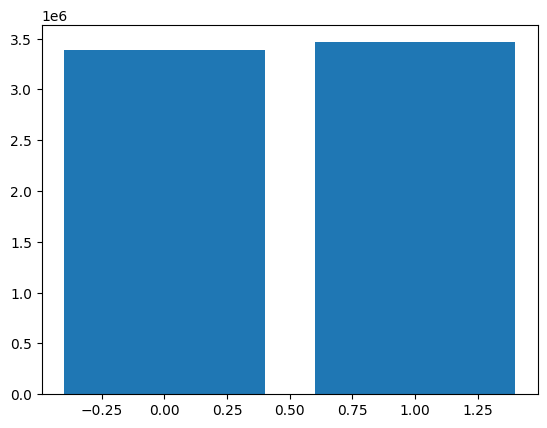

In [46]:
unique_classes, counts = np.unique(train['target'], return_counts = True)

plt.bar(unique_classes, counts)

<b><h3 id="section4">Разделение на train и test</h3></b>

In [ ]:
target = train.pop('target')

In [85]:
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

In [86]:
print(x_train.shape)
print(y_train.shape)

(5477797, 179)
(5477797,)


In [87]:
print(x_test.shape)
print(y_test.shape)

(1369450, 179)
(1369450,)


<b><h3 id="section5">Отбор признаков с помощью Random Forest</h3></b>

Обучим стандартный случайный лес на нашей тренировочной выборке после разделения и посмотрим на веса, которые сопоставила модель каждому признаку, после чего выберем наибольшие

In [88]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

In [ ]:
y_pred = rf.predict(x_test)